In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from networkx.algorithms import bipartite
from test_and_graphing import community_detection, community_strength
from cluster_detection import weighted_welford_example, detect_cluster_basecase_test, detect_cluster_structure
from elbow_detection import calc_lambda_max, calc_weights, calc_elbow
from helper_functions import sum_from_diag, mean_from_diag, calc_from_diag, find_clusters, var_from_diag, reorder_cosine_matrix, compute_cosine_matrix
from sklearn.cluster import KMeans
from IPython.display import display

In [49]:
def draw_graph(A:np.ndarray, group_labels=None, top_nodes=None):
    pos = None
    G = nx.from_numpy_array(A)
    if top_nodes is not None:
        bottom_nodes = set(G.nodes()) - top_nodes
        nx.set_node_attributes(G, {n: 0 for n in top_nodes}, name='bipartite')
        nx.set_node_attributes(G, {n: 1 for n in bottom_nodes}, name='bipartite')
        pos = nx.bipartite_layout(G, top_nodes)
    else: 
        pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color="black")

# graph structure

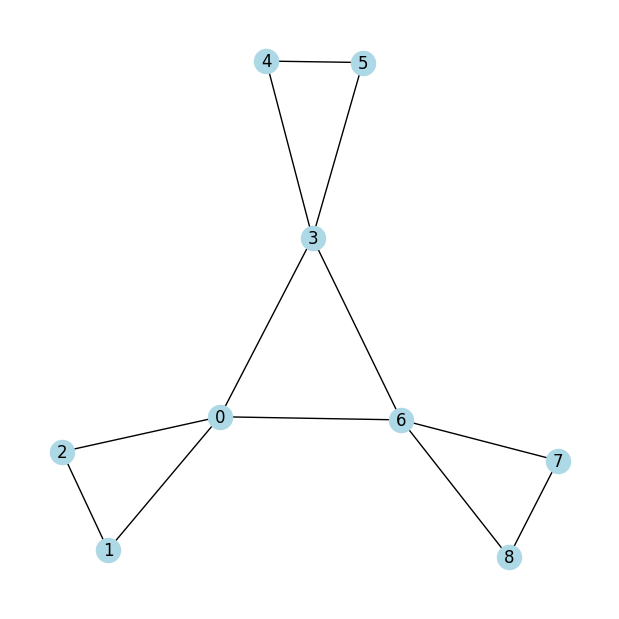

In [50]:
# AL = {
#     0: [1,3],
#     1: [0,2],
#     2: [1,3],
#     3: [0,2,4,6],
#     4: [3,5],
#     5: [4,6],
#     6: [3,5],
# }

AL = {
    0: [1,2,3,6],
    1: [0,2],
    2: [0,1],
    3: [4,5,0,6],
    4: [3,5],
    5: [3,4],
    6: [7,8,0,3],
    7: [6,8],
    8: [6,7]
}

# AL = {
#     0: [1,2,3],
#     1: [0,2,3],
#     2: [0,1,3],
#     3: [0,2,4,1],
#     4: [5,7,6,3],
#     5: [4,6,7],
#     6: [5,7,4],
#     7: [4,5,6],
# }

# AL = {
#     0: [1,5],
#     1: [0,2],
#     2: [1,3],
#     3: [2,4],
#     4: [3,5],
#     5: [4,0]
# }

# AL = nx.to_dict_of_lists(nx.davis_southern_women_graph())
# AL = nx.to_dict_of_lists(nx.karate_club_graph())
# AL = nx.to_dict_of_lists(nx.watts_strogatz_graph(n=100, k=6, p=0.05))

# top_nodes, bottom_nodes = bipartite.sets(nx.davis_southern_women_graph())

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [51]:
L_ABS = D + A
U, S, Vt = np.linalg.svd(L_ABS)
V = Vt.T
S = np.diag(S)

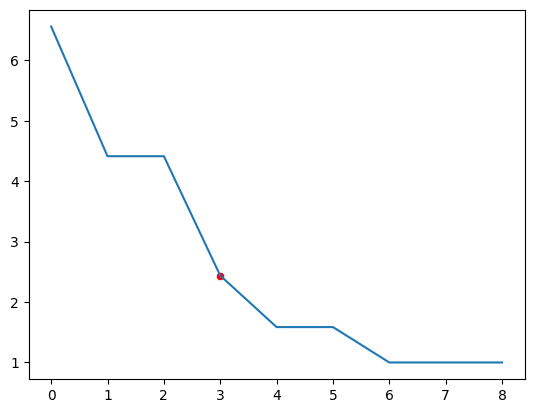

In [52]:
svs = np.diag(S)
# svs_decrease = np.abs(np.diff(svs, prepend=svs[0]))
k = calc_elbow(svs, conf=0.6)
U_k = U[:,0:k+1]
S_k = S[0:k+1,0:k+1]
V_k = V[:,0:k+1]
sns.lineplot(svs)
sns.scatterplot(x=[k], y=[svs[k]], color='red')
# sns.barplot(x=list(range(len(svs_decrease))), y=svs_decrease, color='indigo')
plt.show()

In [53]:
weighted_welford_example(L_ABS)

3.944304526105059e-31
3.254051234036674e-30


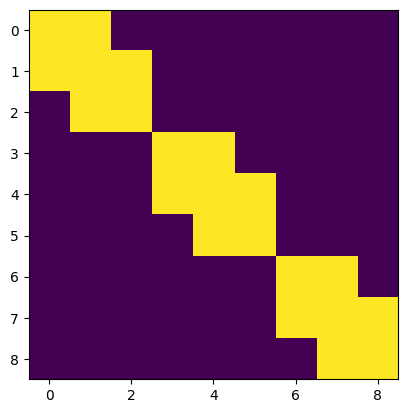

In [54]:
CM = compute_cosine_matrix(S_k, V_k, m, n)
(CM_REORDERED, INDEX) = reorder_cosine_matrix(CM=CM, index=True)
mat = detect_cluster_basecase_test(CM_REORDERED, 0.15)
plt.imshow(mat)
# print(mat)

[range(0, 3), range(3, 6), range(6, 9)]


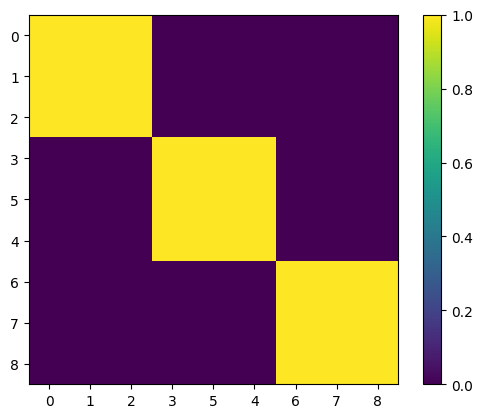

In [55]:
cluster_result = detect_cluster_structure(CM_REORDERED)
print(find_clusters(cluster_result))
plt.imshow(cluster_result, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

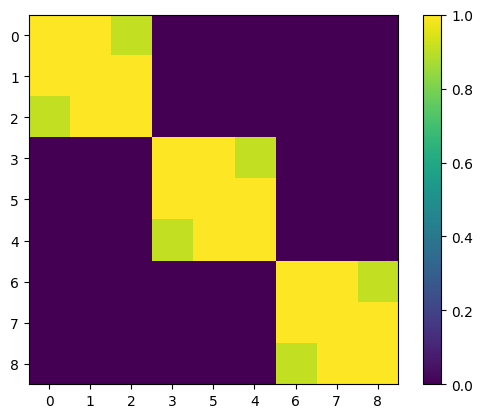

In [57]:
from helper_functions import size_from_diag
(W, M, M2) = detect_cluster_structure(CM_REORDERED, debug=True)
plt.imshow(W / size_from_diag(W), cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()